<a href="https://colab.research.google.com/github/eman-kom/tensorflow-fundamentals/blob/main/09_SkimLit_Milestone_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
NLP model to make reading medical abstracts easier

## Paper referenced:
* [https://arxiv.org/abs/1710.06071](https://arxiv.org/abs/1710.06071)
* [https://arxiv.org/abs/1612.05251](https://arxiv.org/abs/1612.05251)

In [87]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-eb898157-ff44-253a-adc1-105e488192ac)


In [88]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import calculate_results

--2022-07-24 06:38:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-24 06:38:18 (48.5 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



# Getting & Pre-Processing Data
Source: [https://github.com/Franck-Dernoncourt/pubmed-rct](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [89]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [90]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [91]:
!head pubmed-rct/PubMed_20k_RCT/train.txt

###24293578
OBJECTIVE	To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
METHODS	A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .
METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .
METHODS	Pain was assessed using the visual analog pain scale ( 0-100 mm ) .
METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .
METHODS	Serum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein

In [92]:
!head pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt

###24293578
OBJECTIVE	To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
METHODS	A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .
METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .
METHODS	Pain was assessed using the visual analog pain scale ( @-@ mm ) .
METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .
METHODS	Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP 

In [93]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [94]:
def get_lines(filename):
  with open(filename, 'r') as f:
    return f.readlines()

In [95]:
train_lines = get_lines(data_dir+"/train.txt")
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [96]:
for i in enumerate(train_lines[:10]):
  print(i)

(0, '###24293578\n')
(1, 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n')
(2, 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n')
(3, 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n')
(4, 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n')
(5, 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n')
(6, 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis fa

In [97]:
def preprocess_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []
  
 
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

     
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target, text = abstract_line.split("\t")
        line_data["target"] = target
        line_data["text"] = text.lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    
    else:
      abstract_lines += line
  
  return abstract_samples

In [98]:
%%time
train_samples = preprocess_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 450 ms, sys: 106 ms, total: 556 ms
Wall time: 584 ms


# Visualising Dataset

In [99]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [100]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

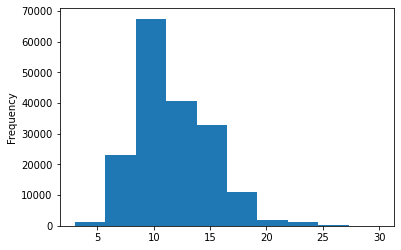

In [101]:
train_df.total_lines.plot.hist();

In [102]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

# Encoding labels

In [103]:
# one hot encoding
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [104]:
# Encode Labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [105]:
classes = label_encoder.classes_
num_classes = len(classes)
classes

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

# Model 0: Baseline Model, TF-IDF Multinomial Naive Bayes Classifier

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(
    train_sentences,
    train_labels_encoded
)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [107]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [108]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [109]:
model_0_results = calculate_results(val_labels_encoded, baseline_preds)
model_0_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

# Preparing text for deep learning

In [110]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [111]:
sent_lengths = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lengths = np.mean(sent_lengths)
avg_sent_lengths

26.338269273494777

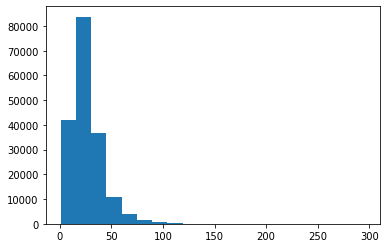

In [112]:
import matplotlib.pyplot as plt
plt.hist(sent_lengths, bins=20);

In [113]:
output_seq_len = int(np.percentile(sent_lengths, 95))
output_seq_len

55

In [114]:
max(sent_lengths)

296

## Vectorizing on training sentences

In [115]:
MAX_TOKENS = 68000

In [116]:
from tensorflow.keras.layers import TextVectorization

In [117]:
vectorizer = TextVectorization(
    max_tokens=MAX_TOKENS,
    output_sequence_length=output_seq_len
)

In [118]:
vectorizer.adapt(train_sentences)

In [119]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text:\n{len(target_sentence.split())}")
print(f"\nVectorized Text:\n{vectorizer([target_sentence])}")

Text:
diagnostic discrepancies were classified as being either clinically relevant ( major ) or clinically not relevant ( minor ) .

Length of text:
20

Vectorized Text:
[[ 712 8944    9 2102   25  571  132  463  963  347   16  463   31  963
  1857    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [120]:
rct_20k_vocab = vectorizer.get_vocabulary()
print(f"Word Count: {len(rct_20k_vocab)}")
print(f"Most common words: {rct_20k_vocab[:5]}")
print(f"Least common words: {rct_20k_vocab[-5:]}")

Word Count: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [121]:
vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization_1',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

## Creating token Embedding

In [122]:
from tensorflow.keras.layers import Embedding 

In [123]:
token_embedding = Embedding(
    input_dim=len(rct_20k_vocab),
    output_dim=128,
    mask_zero=True,
    name="token_embedding"
)

In [124]:
print(f"Normal:\n{target_sentence}")
print(f"\nVectorized:\n{vectorizer([target_sentence])}")
print(f"\nVectorized shape: {vectorizer([target_sentence]).shape}")
print(f"\nEmbedding:\n{token_embedding(vectorizer([target_sentence]))}")
print(f"\nEmbedding shape: {token_embedding(vectorizer([target_sentence])).shape}")

Normal:
diagnostic discrepancies were classified as being either clinically relevant ( major ) or clinically not relevant ( minor ) .

Vectorized:
[[ 712 8944    9 2102   25  571  132  463  963  347   16  463   31  963
  1857    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Vectorized shape: (1, 55)

Embedding:
[[[ 0.03765878  0.02045349  0.0033878  ...  0.008141    0.03536984
    0.0222783 ]
  [-0.00854474  0.02293645 -0.03676562 ...  0.00662171  0.02894989
   -0.01333184]
  [-0.02971691  0.04218772 -0.01441482 ... -0.03022249 -0.02637391
   -0.03539839]
  ...
  [-0.01733179 -0.04439471 -0.00620625 ...  0.03372172 -0.00960412
    0.0445132 ]
  [-0.01733179 -0.04439471 -0.00620625 ...  0.03372172 -0.00960412
    0.0445132 ]
  [-0.01733179 -0.04439471 -0.00620625 ...  0.03372172 -0.00960412
    0.0445132 ]]]

Embedding shape: (1, 5

# Creating Datasets

In [125]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [126]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1: Conv1D with token embeddings

In [127]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = vectorizer(inputs)
token_embeddings = token_embedding(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_6 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_6   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_10 (Dense)            (None, 5)                 325 

In [128]:
history_model_1 = model_1.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_dataset)),
    epochs=3,
    validation_data=valid_dataset,
    validation_steps=int(0.1*len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 6s 9ms/step - loss: 0.9152 - accuracy: 0.6387 - val_loss: 0.6855 - val_accuracy: 0.7380
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6575 - accuracy: 0.7563 - val_loss: 0.6353 - val_accuracy: 0.7680
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6213 - accuracy: 0.7739 - val_loss: 0.6010 - val_accuracy: 0.7829


In [129]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6030 - accuracy: 0.7824


[0.6030109524726868, 0.7823712229728699]

In [130]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.2435333e-01, 1.9375083e-01, 8.3421513e-02, 2.7775306e-01,
         2.0721277e-02],
        [4.6583033e-01, 2.5635341e-01, 1.2793462e-02, 2.5814217e-01,
         6.8807150e-03],
        [1.2728292e-01, 8.0066361e-03, 1.2706015e-03, 8.6340731e-01,
         3.2495474e-05],
        ...,
        [3.6791150e-06, 9.6550508e-04, 6.4711430e-04, 3.6123611e-06,
         9.9838006e-01],
        [4.8770394e-02, 3.9419609e-01, 1.2361288e-01, 6.4665847e-02,
         3.6875486e-01],
        [2.0006555e-01, 6.5951622e-01, 3.9081987e-02, 3.7282117e-02,
         6.4054094e-02]], dtype=float32), (30212, 5))

In [131]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results, model_0_results

({'accuracy': 78.23712432146166,
  'f1': 0.7801377338514306,
  'precision': 0.7792691546601189,
  'recall': 0.7823712432146167},
 {'accuracy': 72.1832384482987,
  'f1': 0.6989250353450294,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869})

# Model 2 Feature Extraction with pretrained token embeddings

In [132]:
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False,
    name="universal_sentence_encoder"
)

In [133]:
random_train_sentence = random.choice(train_sentences)
print(random_train_sentence)
USE_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(USE_embedded_sentence[0][:10])
print(len(USE_embedded_sentence[0]))

agreement of rv lead position was found in @ ( @ % ) patients with fluoroscopy showing a @-segment and @-segment error in @ ( @ % ) and @ ( @ % ) patients , respectively .
tf.Tensor(
[ 0.00912203  0.03754623 -0.03213222 -0.00278624  0.02565906 -0.05430429
  0.01944746  0.03798856 -0.01871854 -0.01054299], shape=(10,), dtype=float32)
512


In [134]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embeddings = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embeddings)
outputs = layers.Dense(5, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_11 (Dense)            (None, 128)               65664     
                                                                 
 dense_12 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [135]:
history_model_2 = model_2.fit(
    train_dataset,
    epochs=3,
    steps_per_epoch=int(0.1*len(train_dataset)),
    validation_data=valid_dataset,
    validation_steps=int(0.1*len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 0.9145 - accuracy: 0.6527 - val_loss: 0.7960 - val_accuracy: 0.6918
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7672 - accuracy: 0.7023 - val_loss: 0.7532 - val_accuracy: 0.7098
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7495 - accuracy: 0.7143 - val_loss: 0.7366 - val_accuracy: 0.7151


In [136]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7383 - accuracy: 0.7149


[0.7383331656455994, 0.7148814797401428]

In [137]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.1840735e-01, 3.6941817e-01, 1.9027594e-03, 2.0268872e-01,
        7.5829485e-03],
       [3.4900114e-01, 5.1674616e-01, 4.1516870e-03, 1.2721154e-01,
        2.8894676e-03],
       [2.3903172e-01, 1.4854078e-01, 2.0722950e-02, 5.4803199e-01,
        4.3672528e-02],
       ...,
       [1.7636183e-03, 5.3746221e-03, 5.1054429e-02, 8.6144323e-04,
        9.4094592e-01],
       [4.3827416e-03, 5.4016907e-02, 2.0167181e-01, 1.9806062e-03,
        7.3794788e-01],
       [1.6902551e-01, 2.2608161e-01, 5.3270406e-01, 7.3897224e-03,
        6.4799063e-02]], dtype=float32)

In [138]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [139]:
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 71.48815040381305,
 'f1': 0.7115580054072203,
 'precision': 0.7149750653035694,
 'recall': 0.7148815040381306}

In [140]:
model_0_results, model_1_results, model_2_results

({'accuracy': 72.1832384482987,
  'f1': 0.6989250353450294,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869},
 {'accuracy': 78.23712432146166,
  'f1': 0.7801377338514306,
  'precision': 0.7792691546601189,
  'recall': 0.7823712432146167},
 {'accuracy': 71.48815040381305,
  'f1': 0.7115580054072203,
  'precision': 0.7149750653035694,
  'recall': 0.7148815040381306})

# Model 3: Conv1D with character embeddings

In [141]:
train_chars = [" ".join(list(sentence)) for sentence in train_sentences]
val_chars = [" ".join(list(sentence)) for sentence in val_sentences]
test_chars = [" ".join(list(sentence)) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [142]:
output_seq_char_len = int(np.percentile([len(sentence) for sentence in train_sentences], 95))
output_seq_char_len

290

In [143]:
import string

NUM_CHAR_TOKENS = len(string.ascii_lowercase + string.digits + string.punctuation) + 2
char_vectorizer = TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=output_seq_char_len,
    name="char_vectorizer"
)

In [144]:
char_vectorizer.adapt(train_chars)
char_vocab = char_vectorizer.get_vocabulary()

print(f"top 5: {char_vocab[:5]}")
print(f"bot 5: {char_vocab[-5:]}")

top 5: ['', '[UNK]', 'e', 't', 'i']
bot 5: ['k', 'x', 'z', 'q', 'j']


In [145]:
random_chars = random.choice(train_chars)
vectorized_chars = char_vectorizer([random_chars])

print(random_chars)
print(vectorized_chars)
print(len(vectorized_chars[0]))

m o s t   i t e m s   a s s e s s e d   b y   t h e   q u e s t i o n n a i r e   h a d   s a t i s f a c t o r y   a n s w e r s   .
tf.Tensor(
[[15  7  9  3  4  3  2 15  9  5  9  9  2  9  9  2 10 22 19  3 13  2 26 16
   2  9  3  4  7  6  6  5  4  8  2 13  5 10  9  5  3  4  9 17  5 11  3  7
   8 19  5  6  9 20  2  8  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0 

In [146]:
char_embedding = Embedding(
    len(char_vocab),
    25, # from the paper
    mask_zero=True,
    name="char_embed"
)

In [147]:
print(char_embedding(vectorized_chars))

tf.Tensor(
[[[ 0.025115    0.01959259 -0.00294635 ... -0.02089711  0.01681309
   -0.01154125]
  [ 0.00573053 -0.04881098  0.01523197 ... -0.02251273 -0.00236058
   -0.01802628]
  [-0.01168151 -0.04052474  0.03193522 ...  0.04050889  0.01197689
    0.02174585]
  ...
  [ 0.03511859 -0.02678525 -0.04900991 ...  0.04379386  0.04944516
    0.02257736]
  [ 0.03511859 -0.02678525 -0.04900991 ...  0.04379386  0.04944516
    0.02257736]
  [ 0.03511859 -0.02678525 -0.04900991 ...  0.04379386  0.04944516
    0.02257736]]], shape=(1, 290, 25), dtype=float32)


In [159]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
vectorizer_layer = char_vectorizer(inputs)
embedding_layer = char_embedding(vectorizer_layer)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(embedding_layer)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(
    inputs=inputs,
    outputs=outputs,
    name="model_3_conv1d")

model_3.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_3.summary()

Model: "model_3_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_11 (Conv1D)          (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_17 (Dense)            (None, 5)              

In [160]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [161]:
history_model_3 = model_3.fit(
    train_char_dataset,
    steps_per_epoch=int(0.1*len(train_char_dataset)),
    epochs=3,
    validation_data=val_char_dataset,
    validation_steps=int(0.1*len(val_char_dataset))
)

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2841 - accuracy: 0.4806 - val_loss: 1.0598 - val_accuracy: 0.5864
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0103 - accuracy: 0.6003 - val_loss: 0.9545 - val_accuracy: 0.6210
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9331 - accuracy: 0.6335 - val_loss: 0.8797 - val_accuracy: 0.6632


In [162]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.8945 - accuracy: 0.6527


[0.8944867253303528, 0.6527207493782043]

In [165]:
model_3_preds = tf.argmax(model_3.predict(val_char_dataset), axis=1)
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results, model_2_results, model_1_results, model_0_results

({'accuracy': 65.2720773202701,
  'f1': 0.641211296748015,
  'precision': 0.649425107709443,
  'recall': 0.6527207732027009},
 {'accuracy': 71.48815040381305,
  'f1': 0.7115580054072203,
  'precision': 0.7149750653035694,
  'recall': 0.7148815040381306},
 {'accuracy': 78.23712432146166,
  'f1': 0.7801377338514306,
  'precision': 0.7792691546601189,
  'recall': 0.7823712432146167},
 {'accuracy': 72.1832384482987,
  'f1': 0.6989250353450294,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869})